In [16]:
import sys 
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

import torch 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from graspologic.embed import AdjacencySpectralEmbed  
from torch_geometric.utils import to_dense_adj

from models.onu_fuctions import load_un_dataset, create_un_graphs
from models.GLASE_unshared_normalized import gLASE 
from models.RDPG_GD import GRDPG_GD_Armijo
from models.SVD_truncate import align_Xs

# 1980

In [4]:
votes_df = load_un_dataset('../data/UNVotes-1.csv', unknown_votes=True)

In [5]:
year = 1980

G = create_un_graphs(votes_df[votes_df.year==year])
G = G.to_undirected()

# rename nodes
mapping = {node: i for i, node in enumerate(G.nodes())}
G_ = nx.relabel_nodes(G, mapping)

country_indexes = []
res_indexes = []
__features = []

for node, data in G_.nodes(data=True):
    if data["type"] == "country":
        country_indexes.append(node)
        __features.append(data['country_features'])
    else:
        res_indexes.append(node)
        __features.append(data['res_features'])


unknown_edges = []

for u, v, data in G_.edges(data=True):
    if data['unknown']:
        unknown_edges.append((u,v))
        unknown_edges.append((v,u))
    

adj_matrix = nx.adjacency_matrix(G_).todense().astype(int)

_features = np.array(__features)
features = torch.tensor(_features)

In [6]:
## Build mask 

num_nodes = adj_matrix.shape[0]
mask_unknown = torch.ones([num_nodes,num_nodes]).squeeze(0)

for u, v, data in G_.edges(data=True):
    if data['unknown']:
        mask_unknown[u,v] = 0
        mask_unknown[v,u] = 0 # Error aca antes

for u,v in unknown_edges:
    if mask_unknown[u,v] != 0:
        print('Error')

In [25]:
d = 4
gd_steps = 20
lr = 1e-2
epochs = 300
device = 'cuda'


## ASE 
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase_orig = ase.fit_transform(adj_matrix)

## Calculate GRDPG Embeddings
edge_index = torch.tensor(adj_matrix).nonzero().t().contiguous()
A = torch.tensor(adj_matrix).float()
u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
q = torch.Tensor(list_q)
Q=torch.diag(q)

x_grdpg_orig, cost, k  = GRDPG_GD_Armijo(torch.tensor(x_ase_orig).float(), edge_index, Q, mask_unknown.nonzero().t().contiguous())
x_grdpg_orig = x_grdpg_orig.detach()



## GLASE
model = gLASE(d,d, gd_steps)
model.init_lase(lr)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask_unknown.nonzero().t().contiguous().to(device)
x_ase_orig = torch.tensor(x_ase_orig).float().to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase_orig, edge_index, edge_index_2, Q, mask)
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)
        
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))

x_glase_orig = out.detach().to('cpu')
x_ase_orig = x_ase_orig.to('cpu')

country_labels = []
missing_countries = []
for node, data in G_.nodes(data=True):
    if data['type'] == 'country':
        country_labels.append(data['country code'])
        if data['country code'] in ['USA', 'RUS', 'ISR', 'JPN', 'NZL' ,'IRL', 'NLD', 'FRA']:
            print(node,data)

        

tensor(292.4355, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(28.6076, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(24.7513, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
0 {'country code': 'USA', 'continent': 'North America', 'country_features': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'yellow', 'type': 'country'}
34 {'country code': 'IRL', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}
35 {'country code': 'NLD', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}
38 {'country code': 'FRA', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'color': 'royalblue', 'type': 'country'}
55 {'country code': 'RUS', 'continent': 'Europe', 'country_features': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0

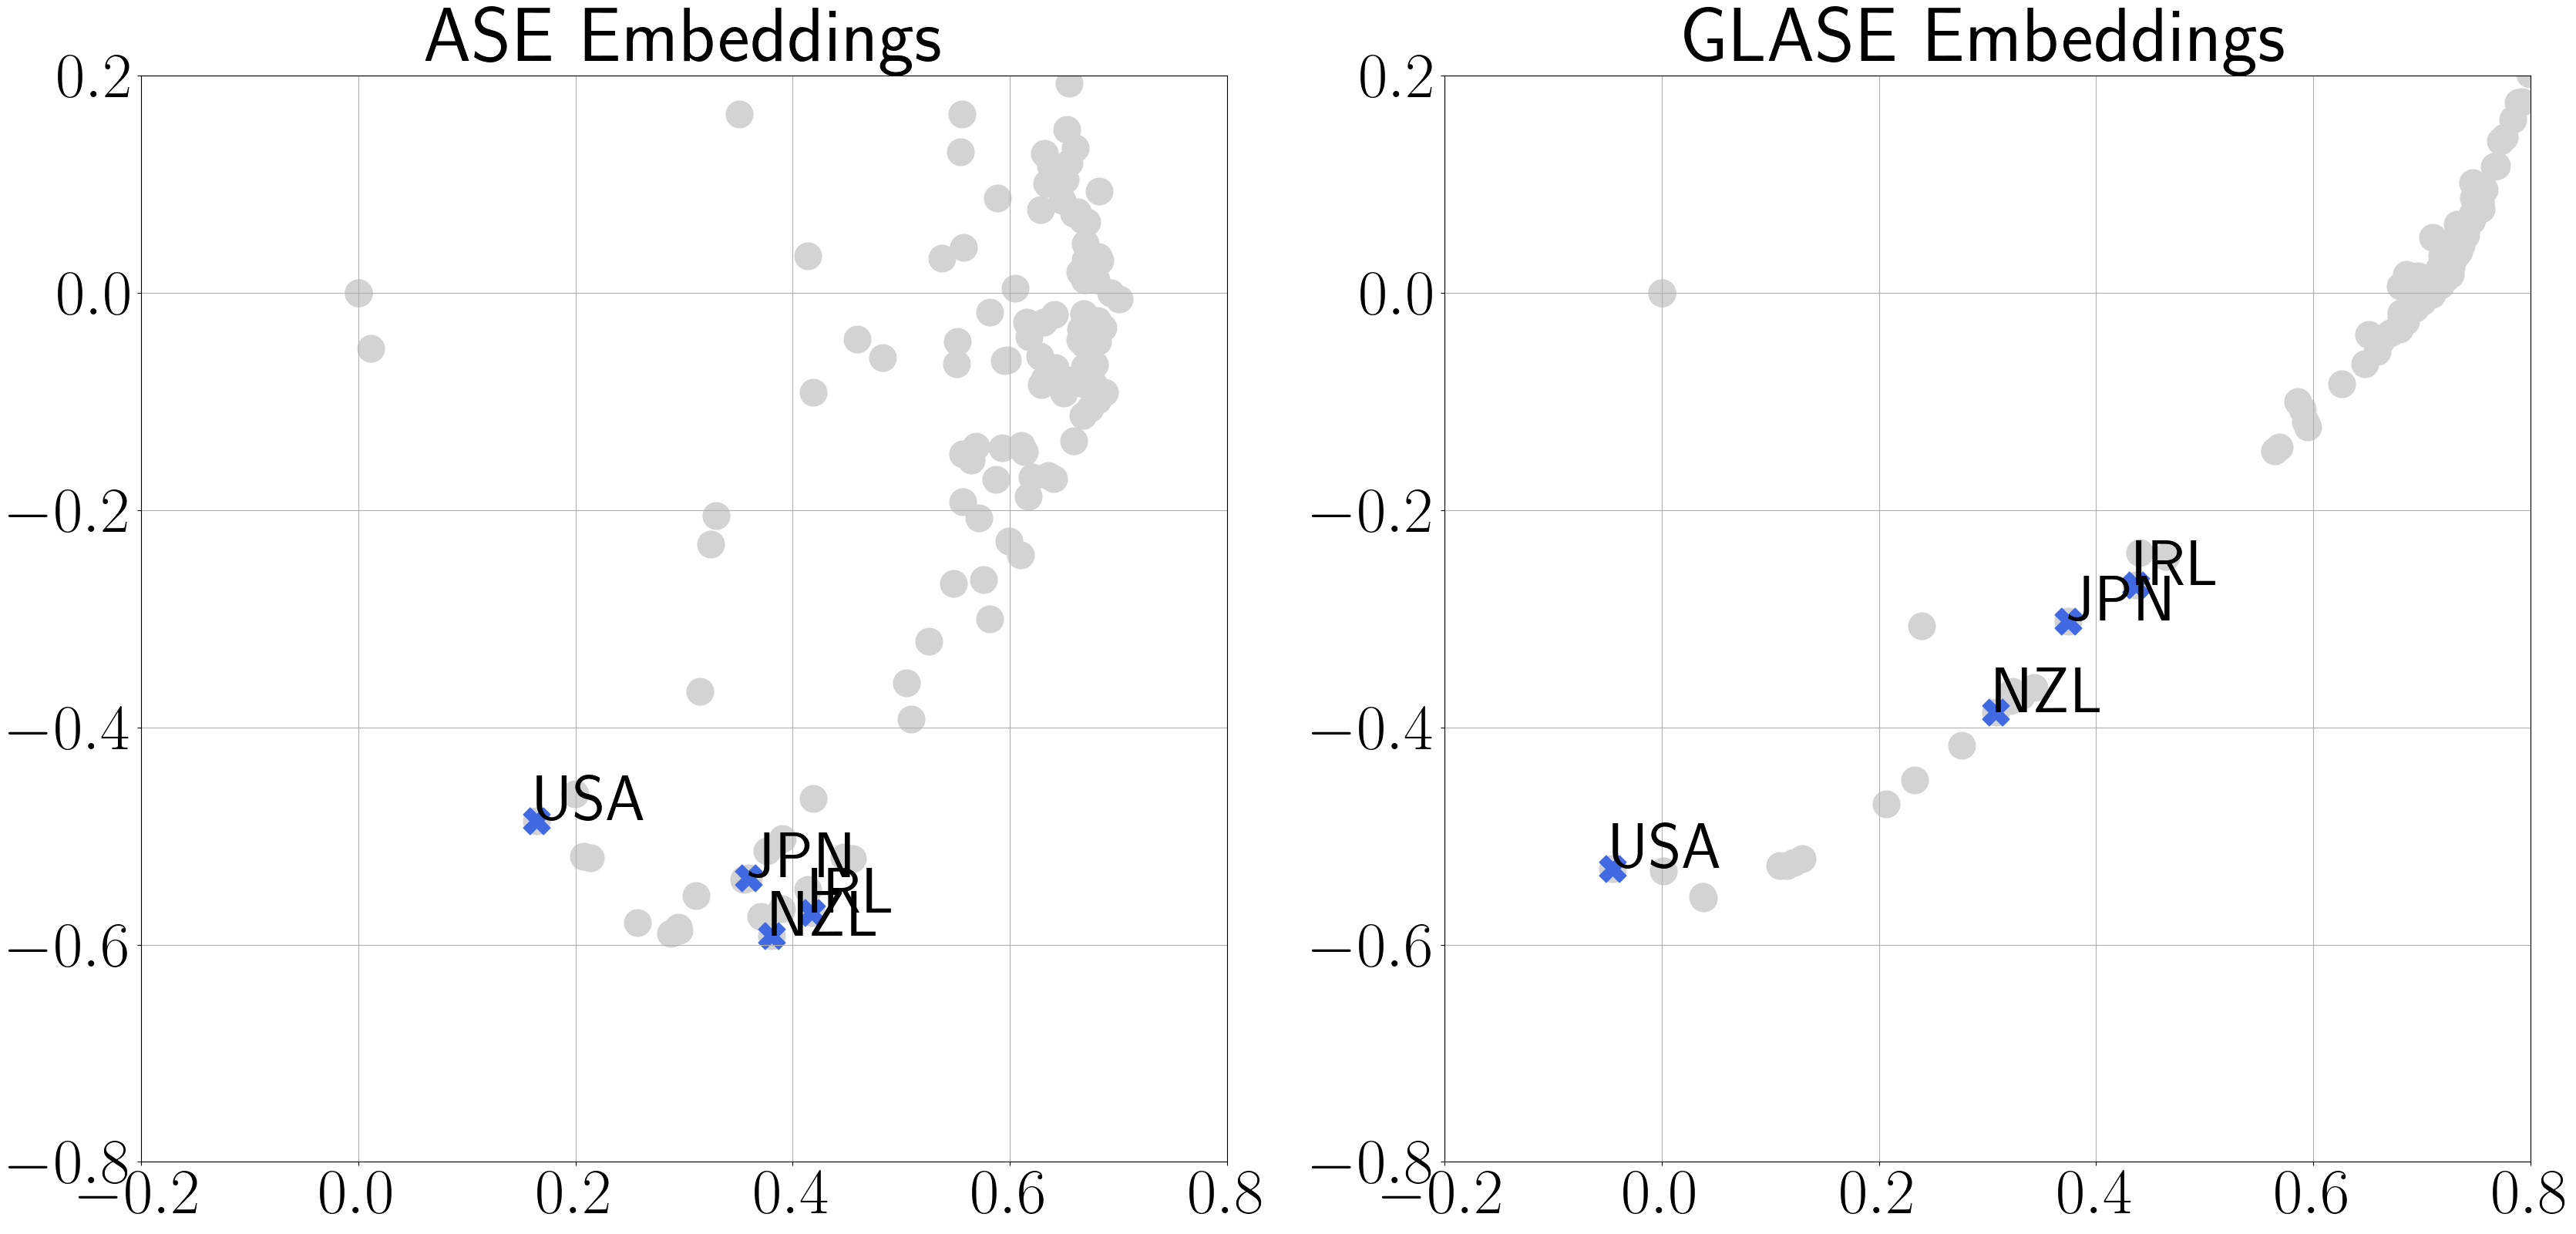

In [8]:
x_grdpg_orig_ = align_Xs(x_grdpg_orig, x_ase_orig)
x_glase_orig_ = align_Xs(x_glase_orig, x_ase_orig)


plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 60
plt.rcParams['lines.markersize'] = 25
plt.rcParams['axes.grid'] = True


fig, axes = plt.subplots(1, 2, figsize =(40,20))
axes[0].scatter(x_ase_orig[country_indexes,1],x_ase_orig[country_indexes,3], c='lightgray',marker='o',label='Countries')
axes[0].scatter(x_ase_orig[0,1],x_ase_orig[0,3], c='royalblue',marker='X')
axes[0].scatter(x_ase_orig[151,1],x_ase_orig[151,3], c='royalblue',marker='X')
axes[0].scatter(x_ase_orig[132,1],x_ase_orig[132,3], c='royalblue',marker='X')
axes[0].scatter(x_ase_orig[34,1],x_ase_orig[34,3], c='royalblue',marker='X')
axes[0].set_xlim(-0.2, 0.8)
axes[0].set_ylim(-0.8, 0.2)
axes[0].set_aspect('equal')
axes[0].set_title('ASE Embeddings')
# Add labels to nodes
for i, label in enumerate(country_labels):
    if label in ['USA', 'IRL', 'JPN', 'NZL']:
        axes[0].annotate(label, (x_ase_orig[country_indexes,1][i], x_ase_orig[country_indexes,3][i]))


axes[1].scatter(x_grdpg_orig_[country_indexes,1],x_grdpg_orig_[country_indexes,3], c='lightgray',marker='o',label='Countries')
axes[1].scatter(x_grdpg_orig_[0,1],x_grdpg_orig_[0,3], c='royalblue',marker='X')
axes[1].scatter(x_grdpg_orig_[151,1],x_grdpg_orig_[151,3], c='royalblue',marker='X')
axes[1].scatter(x_grdpg_orig_[132,1],x_grdpg_orig_[132,3], c='royalblue',marker='X')
axes[1].scatter(x_grdpg_orig_[34,1],x_grdpg_orig_[34,3], c='royalblue',marker='X')
axes[1].set_xlim(-0.2, 0.8)
axes[1].set_ylim(-0.8, 0.2)
axes[1].set_aspect('equal')
axes[1].set_title('GLASE Embeddings')


#', Add labels to nodes
for i, label in enumerate(country_labels):
    if label in ['USA', 'IRL', 'JPN', 'NZL']:
        axes[1].annotate(label, (x_grdpg_orig_[country_indexes,1][i], x_grdpg_orig_[country_indexes,3][i]))

plt.show()

# Analisis resultados - random countries

In [9]:
# Specify the path to your CSV file
csv_file_path = '../training/results/onu/onu_original_feat_results.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path, sep=';', header=None, names = ['Year', 'masked_countries' ,'masked_resolutions', 'GCN', 'ASE', 'GD_GRDPG', 'GLASE','GLASE_e2e'])

# Convert string representation of lists to actual lists
df['GCN'] = df['GCN'].apply(lambda x: ast.literal_eval(x))
df['ASE'] = df['ASE'].apply(lambda x: ast.literal_eval(x))
df['GD_GRDPG'] = df['GD_GRDPG'].apply(lambda x: ast.literal_eval(x))
df['GLASE'] = df['GLASE'].apply(lambda x: ast.literal_eval(x))
df['GLASE_e2e'] = df['GLASE_e2e'].apply(lambda x: ast.literal_eval(x))

# Create a new column with the mean value of each list in 'Column1'
df['GCN_mean'] = df['GCN'].apply(lambda x: sum(x) / len(x))
df['ASE_mean'] = df['ASE'].apply(lambda x: sum(x) / len(x))
df['GD_mean'] = df['GD_GRDPG'].apply(lambda x: sum(x) / len(x))
df['GLASE_mean'] = df['GLASE'].apply(lambda x: sum(x) / len(x))
df['GLASE_e2e_mean'] = df['GLASE_e2e'].apply(lambda x: sum(x) / len(x))

df['GCN_std'] = df['GCN'].apply(lambda x: np.std(x))
df['ASE_std'] = df['ASE'].apply(lambda x: np.std(x))
df['GD_std'] = df['GD_GRDPG'].apply(lambda x: np.std(x))
df['GLASE_std'] = df['GLASE'].apply(lambda x: np.std(x))
df['GLASE_e2e_std'] = df['GLASE_e2e'].apply(lambda x: np.std(x))

df['GCN_mean_std'] = df.apply(lambda row: f"{row['GCN_mean']:.2f} +/- {row['GCN_std']:.2f}", axis=1)
df['ASE_mean_std'] = df.apply(lambda row: f"{row['ASE_mean']:.2f} +/- {row['ASE_std']:.2f}", axis=1)
df['GD_mean_std'] = df.apply(lambda row: f"{row['GD_mean']:.2f} +/- {row['GD_std']:.2f}", axis=1)
df['GLASE_mean_std'] = df.apply(lambda row: f"{row['GLASE_mean']:.2f} +/- {row['GLASE_std']:.2f}", axis=1)
df['GLASE_e2e_mean_std'] = df.apply(lambda row: f"{row['GLASE_e2e_mean']:.2f} +/- {row['GLASE_e2e_std']:.2f}", axis=1)

df[['Year','GCN_mean_std', 'ASE_mean_std', 'GD_mean_std', 'GLASE_mean_std','GLASE_e2e_mean_std']]

,Year,GCN_mean_std,ASE_mean_std,GD_mean_std,GLASE_mean_std,GLASE_e2e_mean_std
0,1946,0.70 +/- 0.01,0.75 +/- 0.05,0.73 +/- 0.06,0.75 +/- 0.03,0.74 +/- 0.04
1,1947,0.57 +/- 0.02,0.72 +/- 0.06,0.71 +/- 0.06,0.70 +/- 0.05,0.76 +/- 0.04
2,1948,0.92 +/- 0.01,0.87 +/- 0.03,0.88 +/- 0.02,0.87 +/- 0.03,0.88 +/- 0.03
3,1949,0.81 +/- 0.04,0.81 +/- 0.01,0.83 +/- 0.02,0.82 +/- 0.02,0.82 +/- 0.01
4,1950,0.92 +/- 0.02,0.91 +/- 0.03,0.91 +/- 0.04,0.90 +/- 0.03,0.90 +/- 0.03
...,...,...,...,...,...,...
67,2014,0.65 +/- 0.02,0.82 +/- 0.13,0.89 +/- 0.09,0.87 +/- 0.10,0.80 +/- 0.11
68,2015,0.77 +/- 0.02,0.82 +/- 0.12,0.87 +/- 0.03,0.85 +/- 0.04,0.87 +/- 0.05
69,2016,0.57 +/- 0.03,0.80 +/- 0.06,0.83 +/- 0.05,0.81 +/- 0.08,0.78 +/- 0.11
70,2017,0.79 +/- 0.04,0.81 +/- 0.06,0.86 +/- 0.05,0.84 +/- 0.07,0.85 +/- 0.07


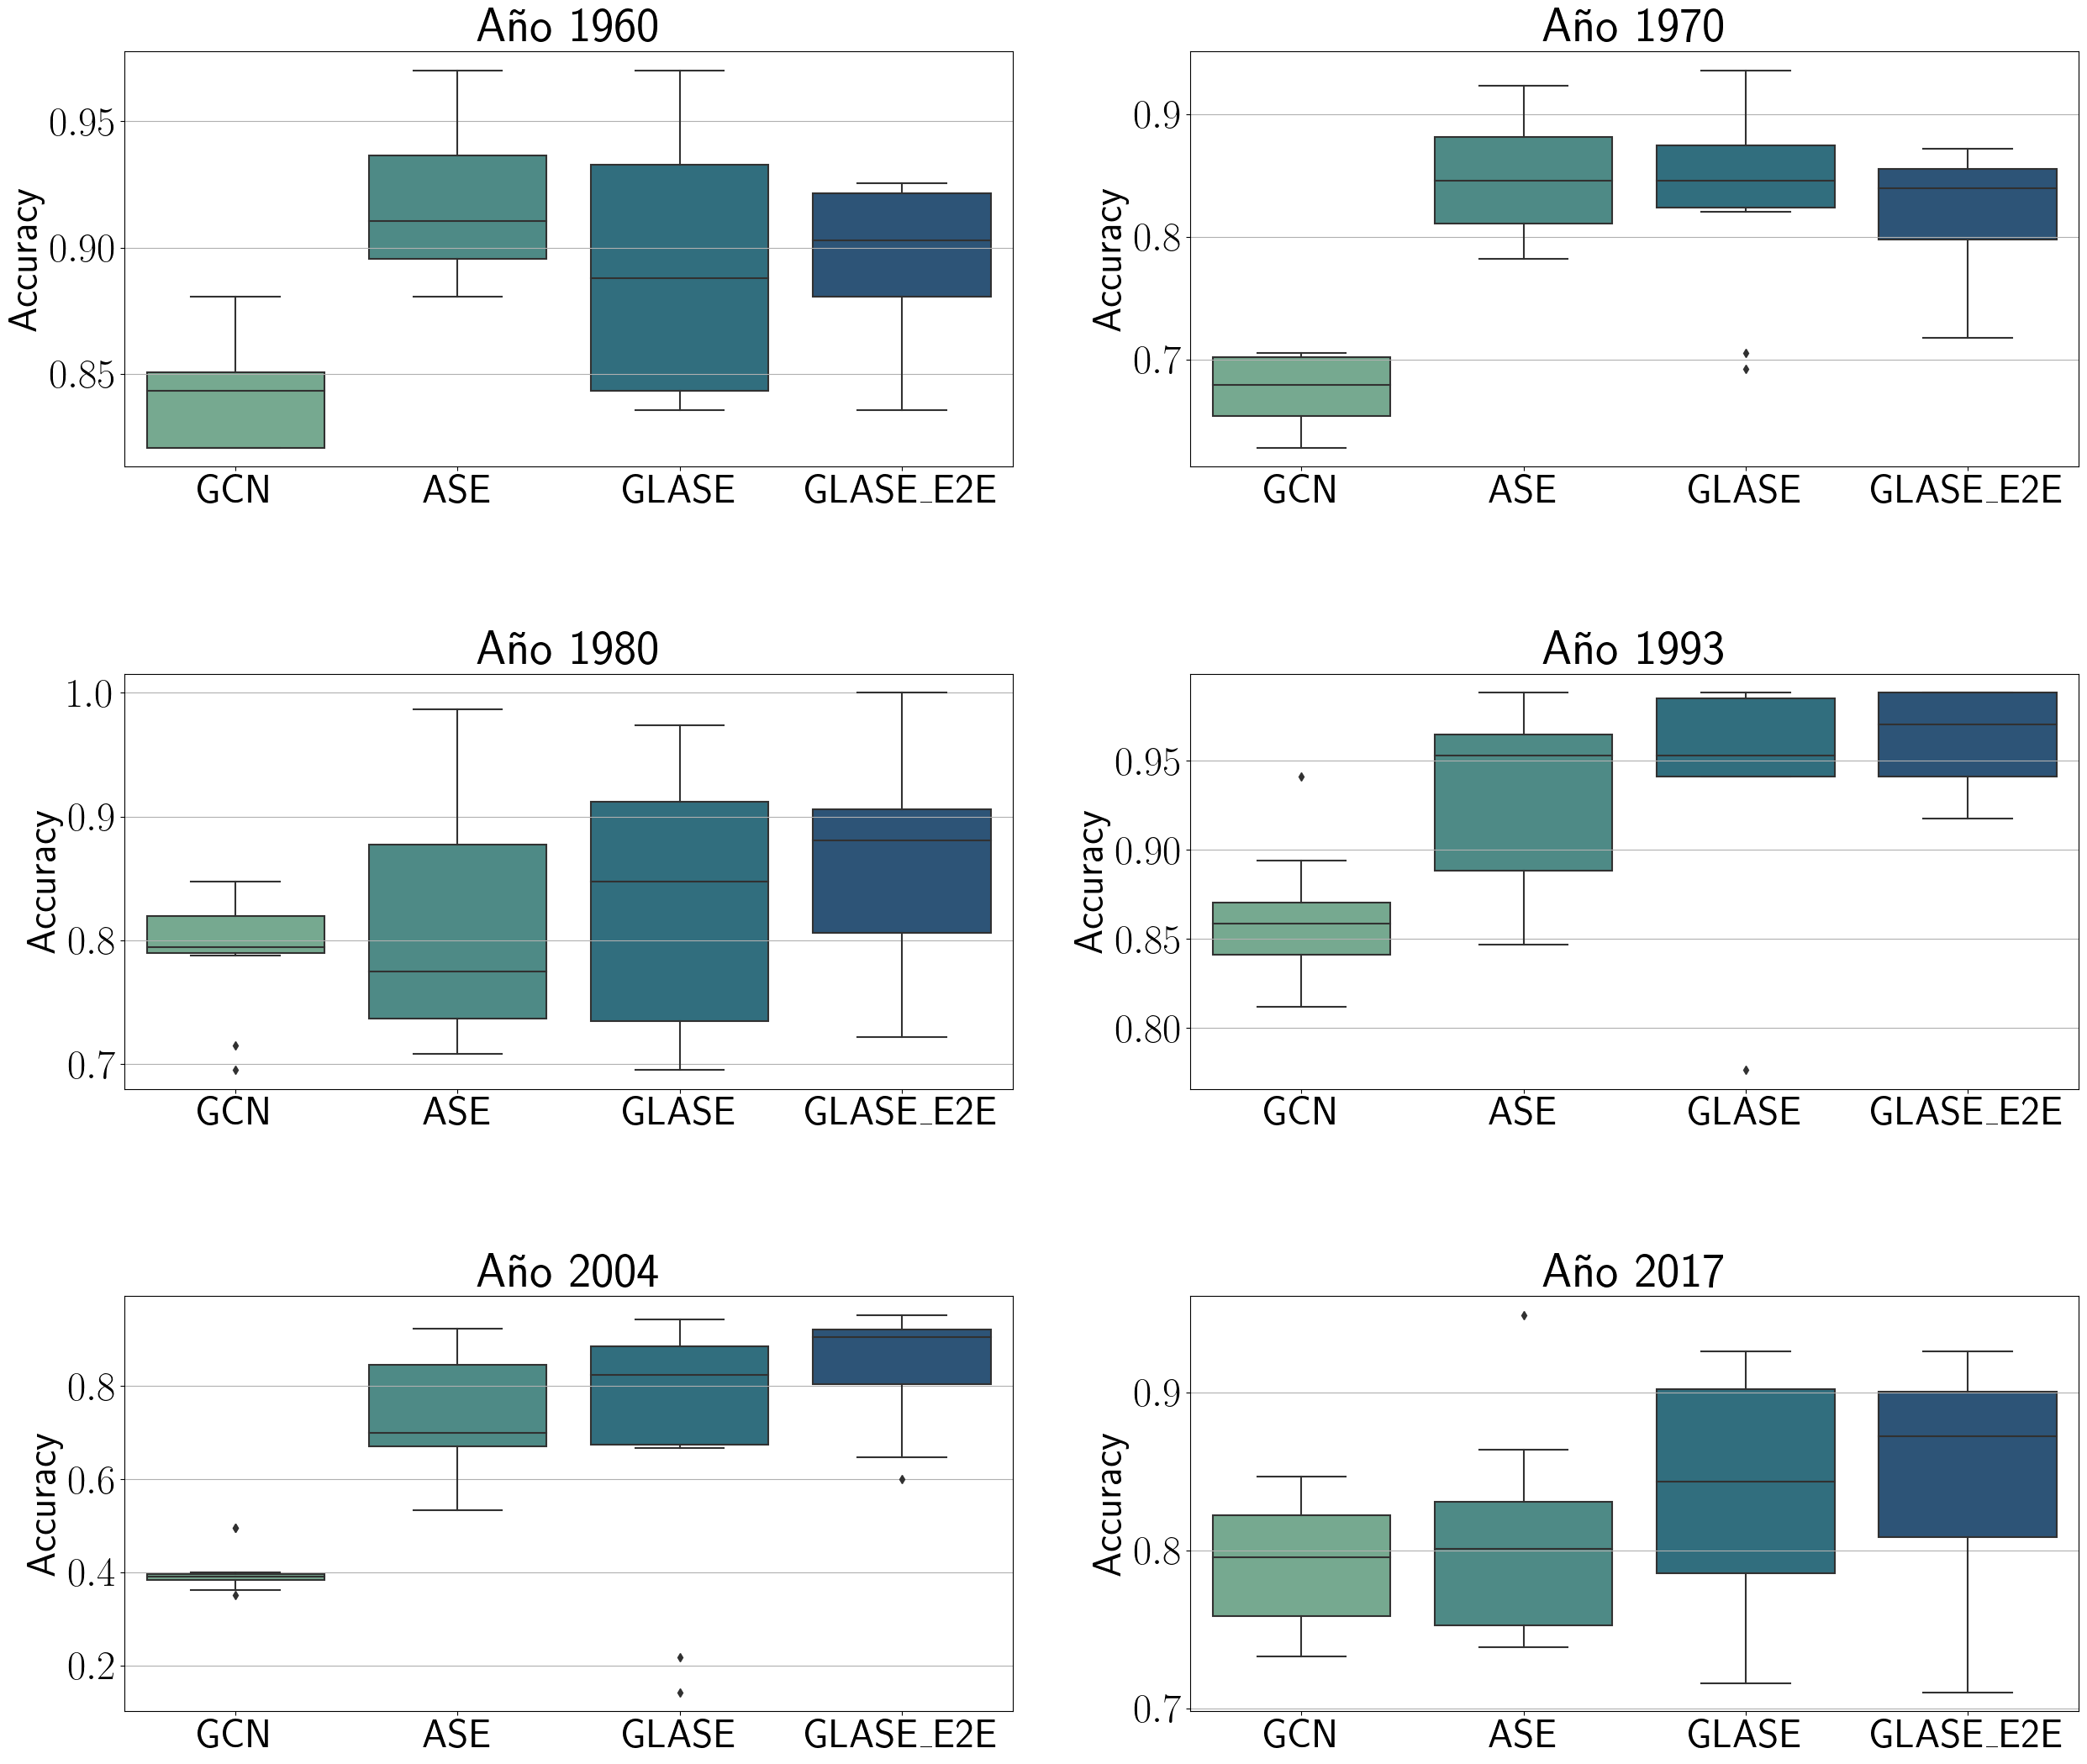

In [10]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 35
plt.rcParams['lines.markersize'] = 20
plt.rcParams['axes.grid'] = True


fig, axes = plt.subplots(3, 2, figsize =(30,25))
plt.subplots_adjust(top=0.9, hspace=0.5)

# Data
year = 1960
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()]

sns.boxplot(data=data_plot, palette="crest", linewidth=1.5, ax=axes[0,0])
axes[0,0].set_xticks(range(0, 4), ['GCN','ASE', 'GLASE', 'GLASE_E2E'])
axes[0,0].set_title(f'Año {year}')
axes[0,0].set_ylabel('Accuracy')

year = 1970
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()]
sns.boxplot(data=data_plot, palette="crest", linewidth=1.5, ax=axes[0,1])
axes[0,1].set_xticks(range(0, 4), ['GCN','ASE', 'GLASE', 'GLASE_E2E'])
axes[0,1].set_title(f'Año {year}')
axes[0,1].set_ylabel('Accuracy')

year = 1980
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()]
sns.boxplot(data=data_plot, palette="crest", linewidth=1.5, ax=axes[1,0])
axes[1,0].set_xticks(range(0, 4), ['GCN','ASE', 'GLASE', 'GLASE_E2E'])
axes[1,0].set_title(f'Año {year}')
axes[1,0].set_ylabel('Accuracy')

year = 1993
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()]
sns.boxplot(data=data_plot, palette="crest", linewidth=1.5, ax=axes[1,1])
axes[1,1].set_xticks(range(0, 4), ['GCN','ASE', 'GLASE', 'GLASE_E2E'])
axes[1,1].set_title(f'Año {year}')
axes[1,1].set_ylabel('Accuracy')

year = 2004
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()]
sns.boxplot(data=data_plot, palette="crest", linewidth=1.5, ax=axes[2,0])
axes[2,0].set_xticks(range(0, 4), ['GCN','ASE', 'GLASE', 'GLASE_E2E'])
axes[2,0].set_title(f'Año {year}')
axes[2,0].set_ylabel('Accuracy')

year = 2017
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()]
sns.boxplot(data=data_plot, palette="crest", linewidth=1.5, ax=axes[2,1])
axes[2,1].set_xticks(range(0, 4), ['GCN','ASE', 'GLASE', 'GLASE_E2E'])
axes[2,1].set_title(f'Año {year}')
axes[2,1].set_ylabel('Accuracy')

# Show the plot
plt.show()


In [11]:
df[['Year','GCN_mean_std']][df[['Year','GCN_mean_std', 'ASE_mean_std', 'GD_mean_std', 'GLASE_mean_std','GLASE_e2e_mean_std']].Year.isin([1960, 1970, 1980, 1993, 2001, 2016])]

,Year,GCN_mean_std
14,1960,0.84 +/- 0.02
23,1970,0.67 +/- 0.03
33,1980,0.79 +/- 0.05
46,1993,0.86 +/- 0.03
54,2001,0.70 +/- 0.04
69,2016,0.57 +/- 0.03


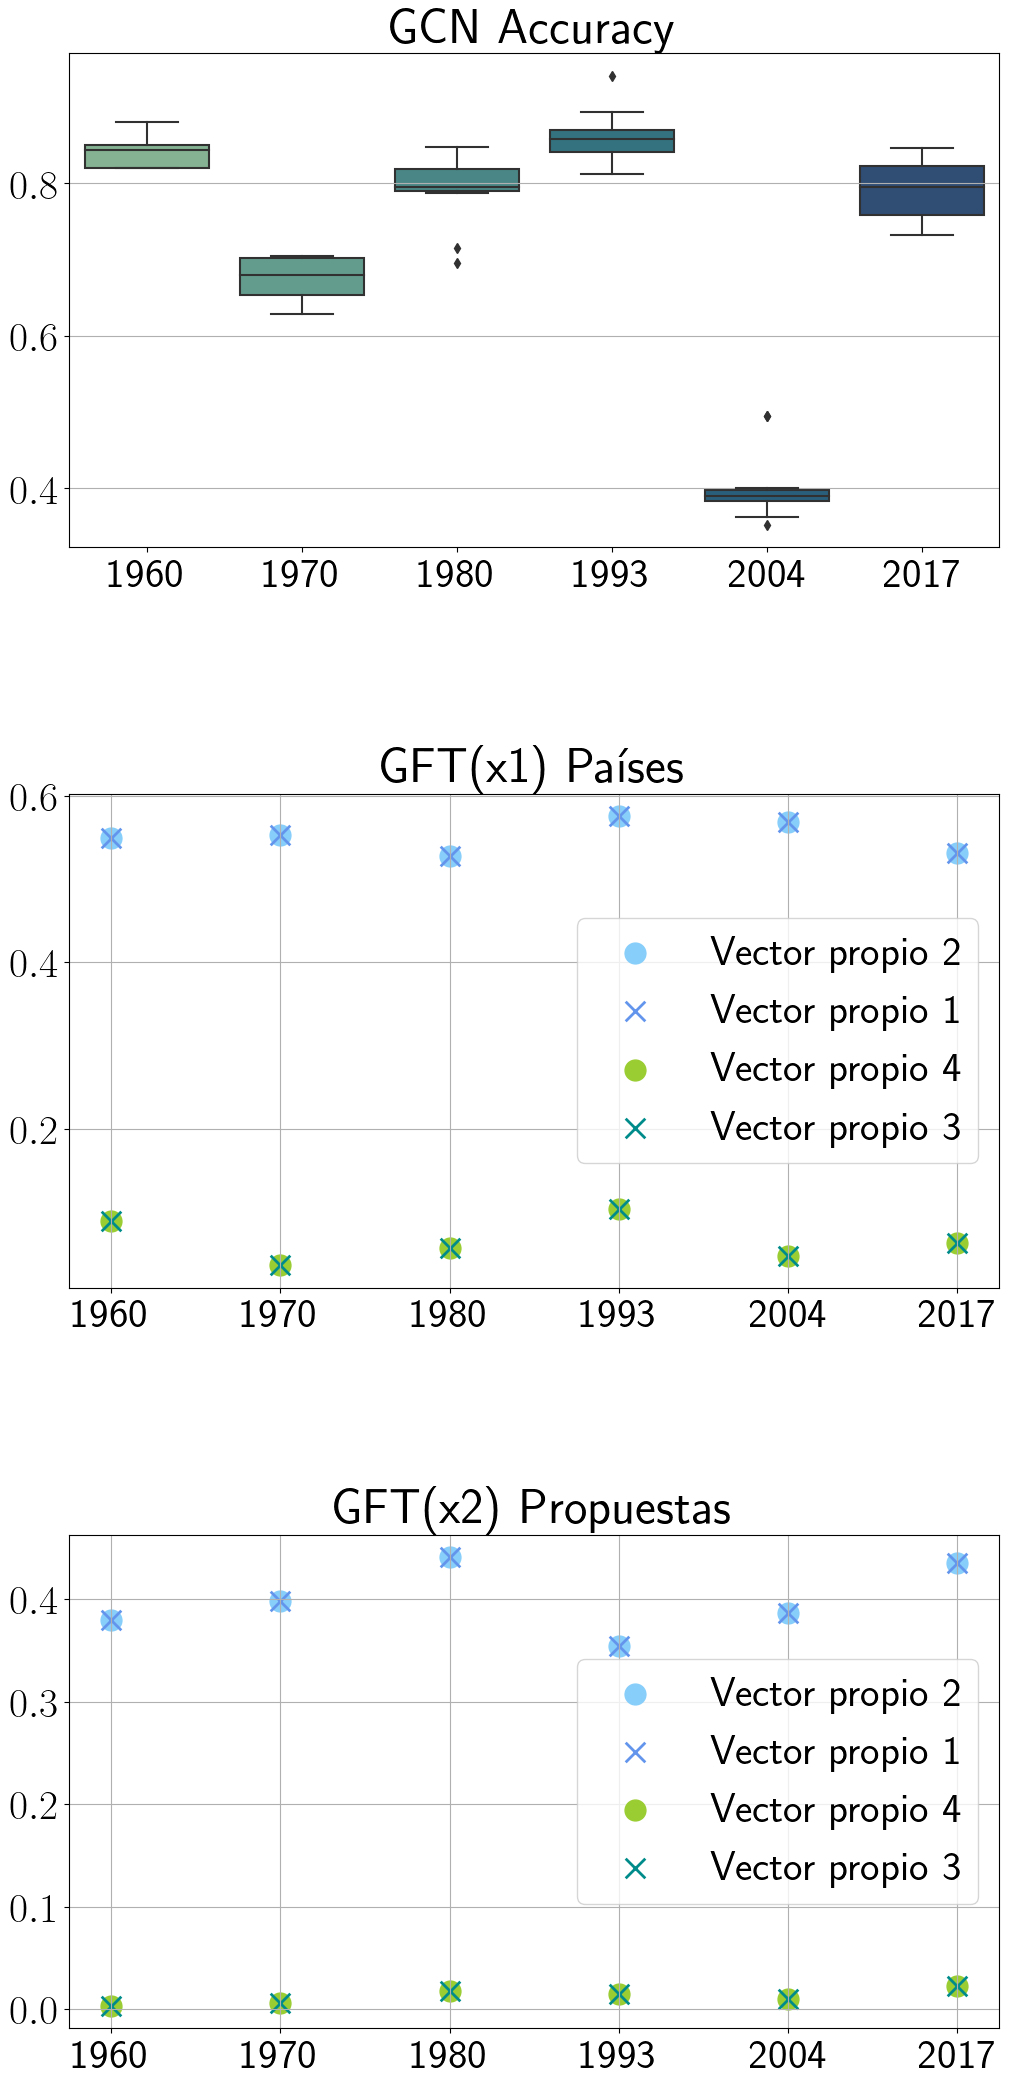

In [12]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 30
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = True


fig, axes = plt.subplots(3, 1, figsize =(12,25))
plt.subplots_adjust(top=0.9, hspace=0.5)


# Data
year = 1960
data_plot = [df[df.Year == 1960]['GCN'].item(), 
             df[df.Year == 1970]['GCN'].item(), 
             df[df.Year == 1980]['GCN'].item(), 
             df[df.Year == 1993]['GCN'].item(),
             df[df.Year == 2004]['GCN'].item(), 
             df[df.Year == 2017]['GCN'].item()
             ]

d1_paises = [0.549, 0.553, 0.527, 0.575, 0.568, 0.531]
d2_paises = [0.549, 0.553, 0.527, 0.575, 0.568, 0.531]
d3_paises = [0.089, 0.036, 0.057, 0.104, 0.047, 0.063]
d4_paises = [0.089, 0.036, 0.057, 0.104, 0.047, 0.063]
d1_leyes = [0.380, 0.398, 0.441, 0.354, 0.386, 0.435]
d2_leyes = [0.380, 0.398, 0.441, 0.354, 0.386, 0.435]
d3_leyes = [0.003, 0.006, 0.018, 0.015, 0.010, 0.022]
d4_leyes = [0.003, 0.006, 0.018, 0.015, 0.010, 0.022]

sns.boxplot(data=data_plot, palette="crest", linewidth=1.5, ax=axes[0])
axes[0].set_xticks(range(0, 6), ['1960','1970', '1980', '1993','2004', '2017'])


axes[1].scatter(range(0, 6), d2_paises, label='Vector propio 2', c='lightskyblue')
axes[1].scatter(range(0, 6), d1_paises, label='Vector propio 1', marker='x', s=200, c='cornflowerblue')
axes[1].scatter(range(0, 6), d4_paises, label='Vector propio 4', c='yellowgreen')
axes[1].scatter(range(0, 6), d3_paises, label='Vector propio 3', marker='x', s=200, c= 'darkcyan')
axes[1].set_xticks(range(0, 6), ['1960','1970', '1980', '1993','2004', '2017'])
axes[1].legend()

axes[2].scatter(range(0, 6), d2_leyes, label='Vector propio 2', c='lightskyblue')
axes[2].scatter(range(0, 6), d1_leyes, label='Vector propio 1', marker='x', s=200, c='cornflowerblue')
axes[2].scatter(range(0, 6), d4_leyes, label='Vector propio 4', c='yellowgreen')
axes[2].scatter(range(0, 6), d3_leyes, label='Vector propio 3', marker='x', s=200, c= 'darkcyan')
axes[2].set_xticks(range(0, 6), ['1960','1970', '1980', '1993','2004', '2017'])
axes[2].legend()
axes[0].set_title(f'GCN Accuracy')
# axes[0].set_xlabel(f'Year')
# axes[0].set_ylabel('Accuracy')
axes[1].set_title(f'GFT(x1) Países')
axes[2].set_title(f'GFT(x2) Propuestas')
# axes[1].set_xlabel(f'Year')

plt.show()

# Analisis resultados - selected countries

In [14]:
# Specify the path to your CSV file
csv_file_path = '../training/results/onu/onu_original_feat_selected_results.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path, sep=';', header=None, names = ['Year', 'masked_countries' ,'masked_resolutions', 'GCN', 'ASE', 'GD_GRDPG', 'GLASE','GLASE_e2e'])

# Convert string representation of lists to actual lists
df['GCN'] = df['GCN'].apply(lambda x: ast.literal_eval(x))
df['ASE'] = df['ASE'].apply(lambda x: ast.literal_eval(x))
df['GD_GRDPG'] = df['GD_GRDPG'].apply(lambda x: ast.literal_eval(x))
df['GLASE'] = df['GLASE'].apply(lambda x: ast.literal_eval(x))
df['GLASE_e2e'] = df['GLASE_e2e'].apply(lambda x: ast.literal_eval(x))

# Create a new column with the mean value of each list in 'Column1'
df['GCN_mean'] = df['GCN'].apply(lambda x: sum(x) / len(x))
df['ASE_mean'] = df['ASE'].apply(lambda x: sum(x) / len(x))
df['GD_mean'] = df['GD_GRDPG'].apply(lambda x: sum(x) / len(x))
df['GLASE_mean'] = df['GLASE'].apply(lambda x: sum(x) / len(x))
df['GLASE_e2e_mean'] = df['GLASE_e2e'].apply(lambda x: sum(x) / len(x))

df['GCN_std'] = df['GCN'].apply(lambda x: np.std(x))
df['ASE_std'] = df['ASE'].apply(lambda x: np.std(x))
df['GD_std'] = df['GD_GRDPG'].apply(lambda x: np.std(x))
df['GLASE_std'] = df['GLASE'].apply(lambda x: np.std(x))
df['GLASE_e2e_std'] = df['GLASE_e2e'].apply(lambda x: np.std(x))

df['GCN_mean_std'] = df.apply(lambda row: f"{row['GCN_mean']:.2f} +/- {row['GCN_std']:.2f}", axis=1)
df['ASE_mean_std'] = df.apply(lambda row: f"{row['ASE_mean']:.2f} +/- {row['ASE_std']:.2f}", axis=1)
df['GD_mean_std'] = df.apply(lambda row: f"{row['GD_mean']:.2f} +/- {row['GD_std']:.2f}", axis=1)
df['GLASE_mean_std'] = df.apply(lambda row: f"{row['GLASE_mean']:.2f} +/- {row['GLASE_std']:.2f}", axis=1)
df['GLASE_e2e_mean_std'] = df.apply(lambda row: f"{row['GLASE_e2e_mean']:.2f} +/- {row['GLASE_e2e_std']:.2f}", axis=1)

df[['Year','GCN_mean_std', 'ASE_mean_std', 'GD_mean_std', 'GLASE_mean_std','GLASE_e2e_mean_std']]

,Year,GCN_mean_std,ASE_mean_std,GD_mean_std,GLASE_mean_std,GLASE_e2e_mean_std
0,1946,0.95 +/- 0.02,0.94 +/- 0.03,0.91 +/- 0.06,0.95 +/- 0.01,0.92 +/- 0.05
1,1947,0.57 +/- 0.07,0.65 +/- 0.08,0.66 +/- 0.10,0.61 +/- 0.07,0.63 +/- 0.10
2,1948,0.87 +/- 0.03,0.78 +/- 0.03,0.76 +/- 0.04,0.78 +/- 0.04,0.79 +/- 0.03
3,1949,0.67 +/- 0.03,0.67 +/- 0.01,0.67 +/- 0.03,0.67 +/- 0.02,0.67 +/- 0.02
4,1950,0.81 +/- 0.04,0.77 +/- 0.09,0.83 +/- 0.03,0.80 +/- 0.05,0.74 +/- 0.09
...,...,...,...,...,...,...
67,2014,0.85 +/- 0.09,0.82 +/- 0.04,0.82 +/- 0.04,0.83 +/- 0.04,0.80 +/- 0.04
68,2015,0.92 +/- 0.02,0.70 +/- 0.12,0.75 +/- 0.08,0.79 +/- 0.08,0.74 +/- 0.07
69,2016,0.36 +/- 0.18,0.71 +/- 0.08,0.71 +/- 0.09,0.72 +/- 0.04,0.71 +/- 0.10
70,2017,0.79 +/- 0.03,0.71 +/- 0.05,0.70 +/- 0.05,0.72 +/- 0.08,0.67 +/- 0.07


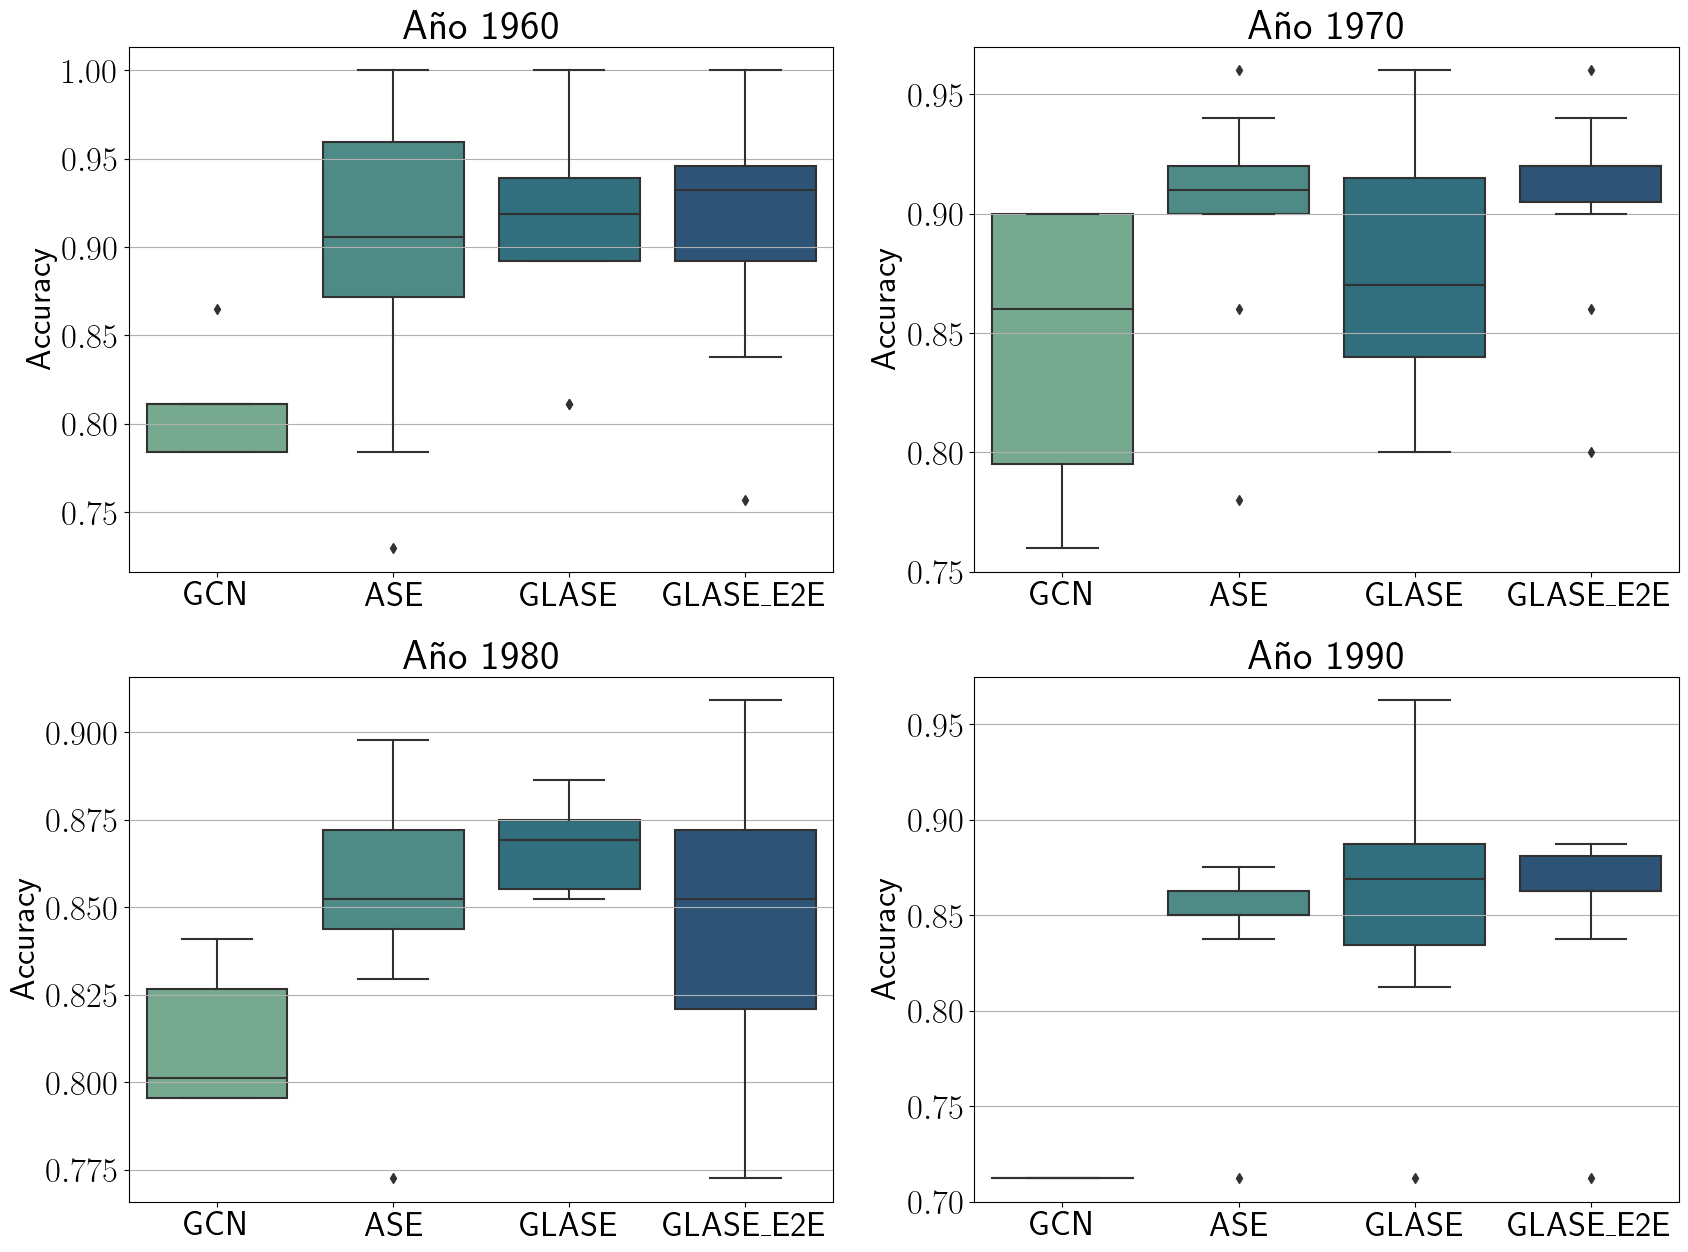

In [15]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 25
plt.rcParams['lines.markersize'] = 20
plt.rcParams['axes.grid'] = True


fig, axes = plt.subplots(2, 2, figsize =(20,15))

# Data
year = 1960
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()]

sns.boxplot(data=data_plot, palette="crest", linewidth=1.5, ax=axes[0,0])
axes[0,0].set_xticks(range(0, 4), ['GCN','ASE', 'GLASE', 'GLASE_E2E'])
axes[0,0].set_title(f'Año {year}')
axes[0,0].set_ylabel('Accuracy')

year = 1970
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()]
sns.boxplot(data=data_plot, palette="crest", linewidth=1.5, ax=axes[0,1])
axes[0,1].set_xticks(range(0, 4), ['GCN','ASE', 'GLASE', 'GLASE_E2E'])
axes[0,1].set_title(f'Año {year}')
axes[0,1].set_ylabel('Accuracy')

year = 1980
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()]
sns.boxplot(data=data_plot, palette="crest", linewidth=1.5, ax=axes[1,0])
axes[1,0].set_xticks(range(0, 4), ['GCN','ASE', 'GLASE', 'GLASE_E2E'])
axes[1,0].set_title(f'Año {year}')
axes[1,0].set_ylabel('Accuracy')

year = 1990
data_plot = [df[df.Year == year]['GCN'].item(), df[df.Year == year]['ASE'].item(), df[df.Year == year]['GLASE'].item(), df[df.Year == year]['GLASE_e2e'].item()]
sns.boxplot(data=data_plot, palette="crest", linewidth=1.5, ax=axes[1,1])
axes[1,1].set_xticks(range(0, 4), ['GCN','ASE', 'GLASE', 'GLASE_E2E'])
axes[1,1].set_title(f'Año {year}')
axes[1,1].set_ylabel('Accuracy')

plt.show()
